# Introduction to Model Predictive Control

## Step Response Data

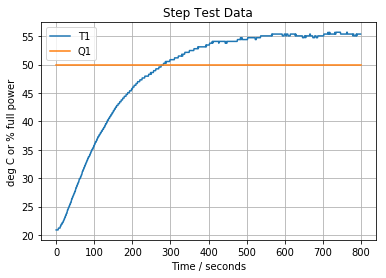

In [85]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('Step_Test_Data.csv')

# time, T1, Q1 data
t = np.array(data['Time'][1:])
T1 = np.array(data['T1'][1:])
Q1 = np.array(data['Q1'][1:])

plt.plot(t,T1,t,Q1)
plt.legend(['T1','Q1'])
plt.title('Step Test Data')
plt.xlabel('Time / seconds')
plt.ylabel('deg C or % full power')
plt.grid()

## Unit Step Response

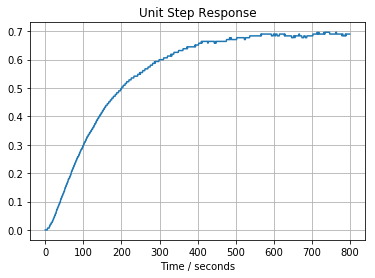

In [86]:
S = (T1 - T1[0])/max(Q1)
plt.plot(t, S)
plt.title('Unit Step Response')
plt.xlabel('Time / seconds')
plt.grid()

## Step Response Matrix

In [87]:
def step_response_matrix(S, ncols=1):
    Smatrix = np.zeros([len(S),ncols])
    for n in range(ncols):
        Smatrix[n:,n] = S[n:]
    return(Smatrix)

# alternative
from scipy.linalg import toeplitz
Smatrix = toeplitz(S,[0,0,0,0,0])

Smatrix[0:30,:]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.0064,  0.    ,  0.    ,  0.    ],
       [ 0.0064,  0.0064,  0.0064,  0.    ,  0.    ],
       [ 0.0064,  0.0064,  0.0064,  0.0064,  0.    ],
       [ 0.0064,  0.0064,  0.0064,  0.0064,  0.0064],
       [ 0.0128,  0.0064,  0.0064,  0.0064,  0.0064],
       [ 0.0128,  0.0128,  0.0064,  0.0064,  0.0064],
       [ 0.0194,  0.0128,  0.0128,  0.0064,  0.0064],
       [ 0.0194,  0.0194,  0.0128,  0.0128,  0.0064],
       [ 0.0194,  0.0194,  0.0194,  0.0128,  0.0128],
       [ 0.0258,  0.0194,  0.0194,  0.0194,  0.0128],
       [ 0.0258,  0.0258,  0.0194,  0.0194,  0.0194],
       [ 0.0258,  0.0258,  0

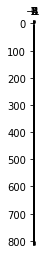

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.spy(Smatrix)

## Computing Response to Changes in Manipulated Variable

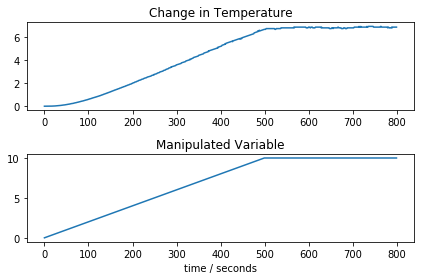

In [89]:
# changes in manipulated variable
du = np.zeros(len(t))
du[0:500] = 0.02

# predict values of output
Smatrix = step_response_matrix(S, len(du))
y_pred = Smatrix.dot(du)

# plot
plt.subplot(2,1,1)
plt.plot(t, y_pred)
plt.title('Change in Temperature')

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du))
plt.title('Manipulated Variable')
plt.xlabel('time / seconds')

plt.tight_layout()

## Computing Inputs Needed to Produce a Desired Output

### Ramp Setpoint

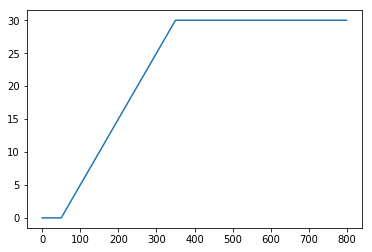

In [90]:
y_setpoint = [0 if (t<50) else 0.1*(t-50) if (t < 350) else 30 for t in t]
plt.plot(t, y_setpoint)

### Confirm the Step Reponse Matrix equations can be solved

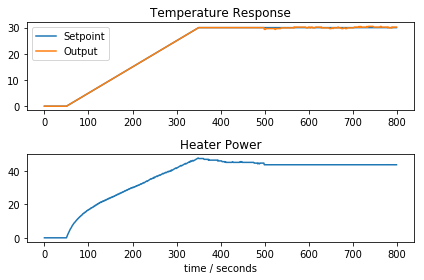

In [91]:
from numpy.linalg import lstsq
import numpy as np

Smatrix = step_response_matrix(S, 500)

du, residuals, rank, s = np.linalg.lstsq(Smatrix, y_setpoint)

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, Smatrix.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

### Let's try a different output response

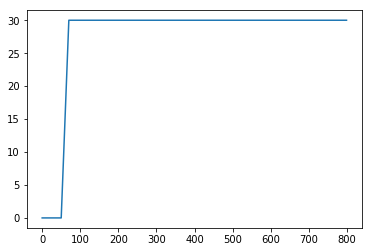

In [92]:
n = 20

y_setpoint = [0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t]
plt.plot(t, y_setpoint)

### Confirm the Step Reponse Matrix equations can be solved

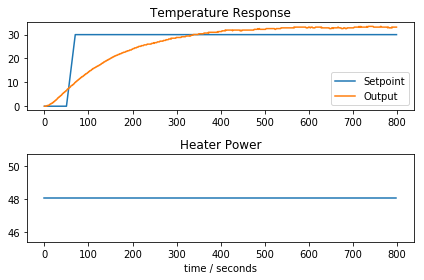

In [149]:
from numpy.linalg import lstsq
import numpy as np

Smatrix = step_response_matrix(S, 1)

du, residuals, rank, s = np.linalg.lstsq(Smatrix, y_setpoint, rcond=0.001)

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, Smatrix.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

Let's make this a feedback loop

/Users/jeff/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


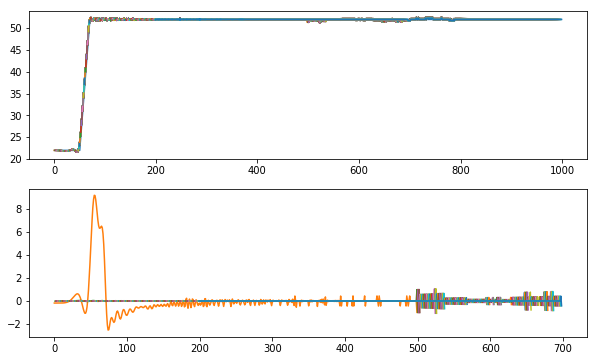

In [189]:
from numpy.linalg import lstsq
import numpy as np

# predictive model
Smatrix = step_response_matrix(S, 500)
P, M = Smatrix.shape

# simulation length
K = 200

u_hist = np.zeros(0)
u = 0

# construct setpoint
n = 20
t = [t for t in range(0, P+K)]
y_setpoint = 22 + np.array([0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t])

plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(t, y_setpoint)

plt.subplot(2,1,2)
plt.plot(0,0)

# initialize simulation
y_pred = 22 + np.zeros(P)

for k in range(K):
    
    y_diff = y_setpoint[k:k+P] - y_pred
    du, residuals, rank, s = np.linalg.lstsq(Smatrix, y_diff, rcond=0.001)
    y_pred = Smatrix.dot(du) + y_pred
    y_pred = np.append(y_pred[1:],y_pred[-1])
    
    plt.subplot(2,1,1)
    plt.plot(t[k:k+P], y_pred)
    
    plt.subplot(2,1,2)
    plt.plot(t[k:k+M], du)
    
    

In [ ]:
for k in range(50):

    du, residuals, rank, s = np.linalg.lstsq(Smatrix, y_setpoint, rcond=0.001)

plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, Smatrix.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(len(t)-len(du)))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()

## Linear Programming with Pyomo

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1800
  Number of variables: 1700
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 52.18524122238159
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


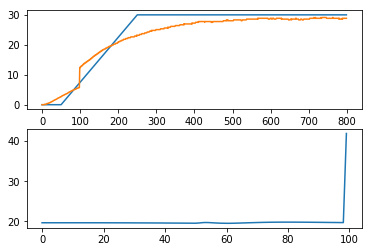

In [115]:
from pyomo.environ import *
import numpy as np

# data
A = np.array([
    [1.0, 0.1], 
    [2.0, 2.0],
    [3.0, -1]])

y_fit = [2, 3, 2]

A = step_response_matrix(S, 100)
n = 200
y_fit = [0 if (t<50) else (30/n)*(t-50) if (t < 50 + n) else 30 for t in t]



M, N = A.shape
assert(M == len(y_fit))

# Pyomo model
model = ConcreteModel()

model.x = Var(range(N), domain=Reals)
model.d = Var(range(M), domain=NonNegativeReals)
model.e = Var(range(M), domain=NonNegativeReals)

model.cons = ConstraintList()
for m in range(M):
    model.cons.add(model.d[m] >= y_fit[m] - sum(model.x[n]*A[m,n] for n in range(N)))
    model.cons.add(model.e[m] >= sum(model.x[n]*A[m,n] for n in range(N)) - y_fit[m])

u = 0
for n in range(N):
    u = u + model.x[n]
    model.cons.add(u <= 100)
    model.cons.add(u >= 0)

model.Objective(expr = sum(model.d[m] + model.e[m] for m in range(M)), sense=minimize)
SolverFactory('ipopt').solve(model).write()

# visualization

%matplotlib inline
import matplotlib.pyplot as plt

du = np.array([model.x[n]() for n in range(N)])

y_pre = y_fit.copy()
for m in range(M):
    y_pre[m] = sum(A[m,n]*model.x[n]() for n in range(N))

plt.subplot(2,1,1)
plt.plot(range(M), y_fit)
plt.plot(range(M), [y_pre[m] for m in range(M)])

plt.subplot(2,1,2)
plt.plot(range(N), np.cumsum(du))

In [49]:
from pyomo.environ import *
import numpy as np

H = len(t)
M = 500

model = ConcreteModel()
model.du = Var(range(M), domain=Reals)


model.constraints = ConstraintList()
for k in range(0,len(model.du)):
    model.constraints.add(model.du[k] <= 100)
    model.constraints.add(model.du[k] >= -100)

v = [( - Smatrix[k].dot(model.du))**2 for k in range(3)]
    
model.OBJ = Objective(expr = sum(v), sense=minimize)

SolverFactory('ipopt').solve(model).write()

du = [model.du[k]() for k in range(0, M)]

ValueError: shapes (2,) and (500,) not aligned: 2 (dim 0) != 500 (dim 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1000
  Number of variables: 500
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0666038990020752
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


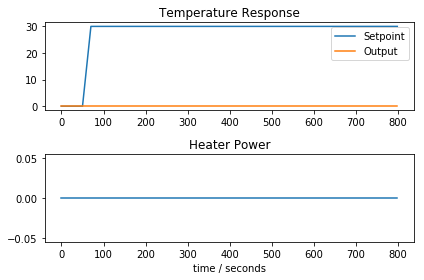

In [171]:
v = [(y_setpoint[k] - Smatrix[k].dot(model.du))**2 for k in range(H)]
print(v)
    
model.OBJ = Objective(expr = sum(v), sense=minimize)

SolverFactory('ipopt').solve(model).write()

du = [model.du[k]() for k in range(0, M)]


plt.subplot(2,1,1)
plt.plot(t, y_setpoint, t, Smatrix.dot(du))
plt.title('Temperature Response')
plt.legend(['Setpoint','Output'])

du_full = np.append(du,np.zeros(H-M))

plt.subplot(2,1,2)
plt.plot(t, np.cumsum(du_full))
plt.title('Heater Power')
plt.xlabel('time / seconds')

plt.tight_layout()